In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import json
import random
import os

import regression_hyperopt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy import stats

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#### Data

In [2]:
TRAIN_SPLIT = .80
VAL_SPLIT = 0.20

SEED = 108

In [3]:
df = pd.read_csv('./pna_dataset.csv')
df.drop(['Unnamed: 22'], axis=1, inplace=True)

In [4]:
df_raw = df.groupby(['PNA sequence (N->C)']).mean()

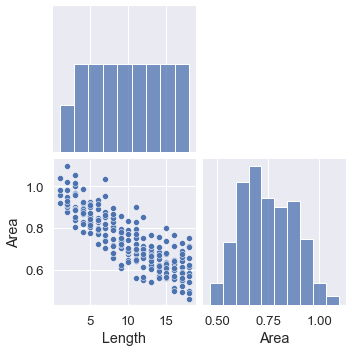

In [25]:
sns.set(font_scale = 1.2)
# sns.set_style('whitegrid')
sns_plot = sns.pairplot(df_raw, 
             corner=True, 
             vars=['Length','Area', ])

#### N-Grams Analysis

In [23]:
importance = []
for column in df_raw.columns[:-1]:
    importance.append((df_raw[column]*df_raw['Area']).sum())
    
df_imp = pd.DataFrame({
    'feature':df_raw.columns[:-1], 
    'importance': importance/sum(importance)}).sort_values(['importance'], ascending=False)
df_imp.reset_index(inplace=True, drop=True)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text major ticklabel objects>)

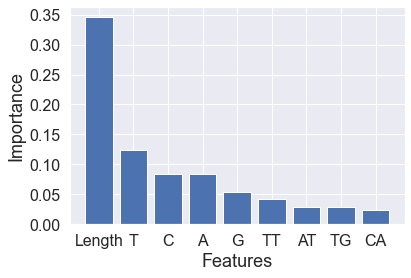

In [24]:
n = 9
fig = plt.figure()
plt.bar(range(n), df_imp['importance'][:n], tick_label=df_imp['feature'][:n])
plt.xlabel('Features', fontsize=18)
plt.ylabel('Importance', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#### Helper Functions

In [5]:
def expt_report(model_tmp, X, Y):
    if len(Y.shape) == 1:
        Y = Y.reshape(-1, 1)
    
    Y_predict = model_tmp.predict(X).reshape(-1, 1)
    
    return {
        'uRMSE': metrics.mean_squared_error(Y, Y_predict),
        'R2': metrics.r2_score(Y, Y_predict),
        'Pearson': np.mean([np.corrcoef(Y_predict.T[idx], Y.T[idx])[0, 1] 
                          for idx in range(Y.T.shape[0])]),
        'Spearman': np.mean([stats.spearmanr(
                            Y_predict.T[idx].reshape(-1, 1), Y.T[idx].reshape(-1, 1))[0]
                                   for idx in range(Y.T.shape[0])]),
    }
    
def regression_report(model_tmp, 
                      valid_X, valid_Y,
                      test_X, test_Y,):
    valid_predict = model_tmp.predict(valid_X).reshape(-1, 1)
    test_predict = model_tmp.predict(test_X).reshape(-1, 1)
    
    if len(test_Y.shape) == 1:
        test_Y = test_Y.reshape(-1, 1)
        
    if len(valid_Y.shape) == 1:
        valid_Y = valid_Y.reshape(-1, 1)
    
    return {
        'Valid_uRMSE': metrics.mean_squared_error(valid_Y, valid_predict),
        'Valid_R2': metrics.r2_score(valid_Y, valid_predict),
        'Valid_Pearson': np.mean([np.corrcoef(valid_predict.T[idx], valid_Y.T[idx])[0, 1] 
                          for idx in range(valid_Y.T.shape[0])]),
        'Valid_Spearman': np.mean([stats.spearmanr(
                            valid_predict.T[idx].reshape(-1, 1), valid_Y.T[idx].reshape(-1, 1))[0]
                                   for idx in range(valid_Y.T.shape[0])]),
        'Test_uRMSE': metrics.mean_squared_error(test_Y, test_predict),
        'Test_R2': metrics.r2_score(test_Y, test_predict),
        'Test_Pearson': np.mean([np.corrcoef(test_predict.T[idx], test_Y.T[idx])[0, 1] 
                          for idx in range(test_Y.T.shape[0])]),
        'Test_Spearman': np.mean([stats.spearmanr(
                            test_predict.T[idx].reshape(-1, 1), test_Y.T[idx].reshape(-1, 1))[0] 
                                  for idx in range(test_Y.T.shape[0])])
    }

#### Training

In [7]:
nnX_sequences = []
nnX = []
nnY = []

for idx in df_raw.index:
    nnX_sequences += [idx]
    nnX += [np.array(df_raw[['Length', 'A', 'T', 'C', 'G', 'AA', 'AT', 'AG', 'AC', 'TT', 'TA', 'TG',
       'TC', 'GG', 'GA', 'GT', 'GC', 'CC', 'CA', 'CT', 'CG']].loc[idx].tolist()).reshape(-1)]
    nnY += [df_raw['Area'].loc[idx]]

nnX_sequences = np.array(nnX_sequences)
nnX = np.array(nnX)
nnY = np.array(nnY)

In [8]:
scaler = StandardScaler()
nnY = scaler.fit_transform(nnY.reshape(-1,1)).reshape(-1)

In [9]:
np.random.seed(108)
indices = np.random.permutation(np.arange((nnX.shape[0])))

In [10]:
nnX_sequences = nnX_sequences[indices]
nnX = nnX[indices]
nnY = nnY[indices]

In [11]:
nnX_sequences_train = nnX_sequences[:int(TRAIN_SPLIT*len(nnX))]
nnX_sequences_test = nnX_sequences[int(TRAIN_SPLIT*len(nnX)):]

nnX_train = nnX[:int(TRAIN_SPLIT*len(nnX))]
nnX_test = nnX[int(TRAIN_SPLIT*len(nnX)):]

nnY_train = nnY[:int(TRAIN_SPLIT*len(nnX))]
nnY_test = nnY[int(TRAIN_SPLIT*len(nnX)):]

#### Model

In [16]:
%%capture

performance = {}
model = regression_hyperopt.Regression()
model.model_sweep(
    nnX_train, nnY_train,
    nnX_test, nnY_test, scaling_function = scaler)

In [17]:
for model_type in model._model_dict:
    print(model_type, model._model_dict[model_type].best_params_)

Linear OrderedDict([('fit_intercept', False), ('normalize', False)])
Ridge OrderedDict([('alpha', 0.0051034198693852935), ('fit_intercept', False), ('normalize', False), ('solver', 'cholesky')])
Lasso OrderedDict([('alpha', 0.0023184733615046775), ('fit_intercept', True), ('normalize', False), ('precompute', True), ('selection', 'random')])
SGD OrderedDict([('alpha', 0.0023184733615046775), ('average', True), ('epsilon', 0.0049377858462389115), ('eta0', 1.73847130094299), ('fit_intercept', True), ('l1_ratio', 0.0038688178689623414), ('learning_rate', 'invscaling'), ('loss', 'huber'), ('penalty', 'l2'), ('power_t', 0.544385078717975)])
MLP OrderedDict([('activation', 'logistic'), ('alpha', 0.001555029238217525), ('beta_1', 0.40155488669107786), ('beta_2', 0.04580419453798915), ('epsilon', 1.6566468028508673e-09), ('learning_rate', 'constant'), ('learning_rate_init', 0.2600895680837739), ('power_t', 0.3580148894273084), ('solver', 'lbfgs')])
GP-Matern OrderedDict([('alpha', 3.48491242093

In [18]:
regression_dict = {}
for model_type in model._model_dict:
    regression_dict[model_type] = regression_report(
        model_tmp=model._model_dict[model_type],
        valid_X=nnX_train[-int((len(nnX_train)*VAL_SPLIT)):],
        valid_Y=nnY_train[-int((len(nnX_train)*VAL_SPLIT)):],
        test_X=nnX_test,
        test_Y=nnY_test)

In [59]:
regression_df = pd.DataFrame.from_dict(regression_dict).T
regression_df

,Valid_uRMSE,Valid_R2,Valid_Pearson,Valid_Spearman,Test_uRMSE,Test_R2,Test_Pearson,Test_Spearman
Linear,8.073756e-02,0.902296,0.954538,0.959514,0.132355,0.859055,0.936532,0.924012
Ridge,8.064867e-02,0.902403,0.953977,0.958420,0.132781,0.858600,0.935062,0.925206
Lasso,8.367214e-02,0.898745,0.951365,0.958639,0.126327,0.865473,0.937956,0.926726
SGD,5.937842e-01,0.281436,0.839233,0.867819,0.702739,0.251649,0.870903,0.863222
MLP,7.994598e-02,0.903254,0.950568,0.953605,0.118337,0.873982,0.941882,0.931285
GP-Matern,2.291452e-12,1.000000,1.000000,1.000000,0.047654,0.949253,0.976080,0.973730
GP-RBF,1.705353e-12,1.000000,1.000000,1.000000,0.082097,0.912574,0.960119,0.952562
SVR,8.028683e-02,0.902841,0.955328,0.963891,0.147535,0.842889,0.930357,0.924446
RandomForest,4.779963e-02,0.942156,0.975121,0.978991,0.134920,0.856323,0.925814,0.907838
XGBoost,1.699458e-03,0.997943,0.999141,0.997812,0.136808,0.854313,0.925886,0.918259


#### Parity Plots

In [20]:
X_features = {
    'Valid': nnX_train[-int((len(nnX_train)*VAL_SPLIT)):],
    'Test': nnX_test,
#     'Experiment': nnX_expt

}

Y_ground_truth = {
    'Valid': scaler.inverse_transform(nnY_train[-int((len(nnX_train)*VAL_SPLIT)):]),
    'Test': scaler.inverse_transform(nnY_test),
#     'Experiment': scaler.inverse_transform(nnY_expt)
}

In [21]:
Y_predict = {key:{} for key in X_features}

for dataset in X_features:
    for model_type in model._model_dict:
        Y_predict[dataset][model_type] = scaler.inverse_transform(
            model._model_dict[model_type].predict(X_features[dataset]))

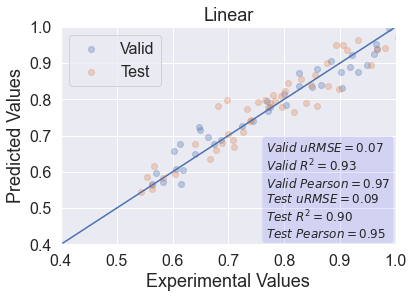

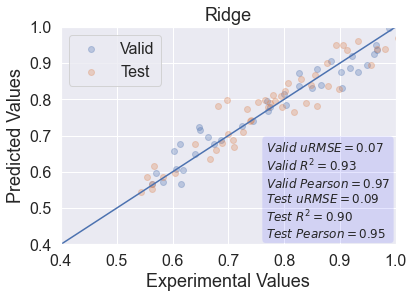

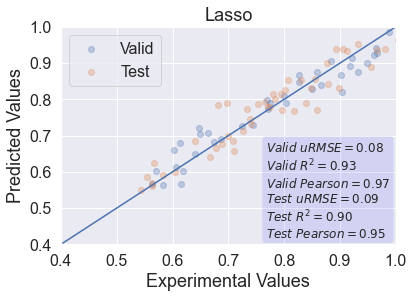

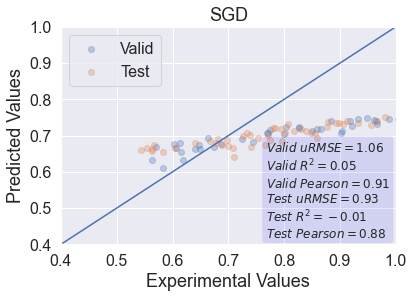

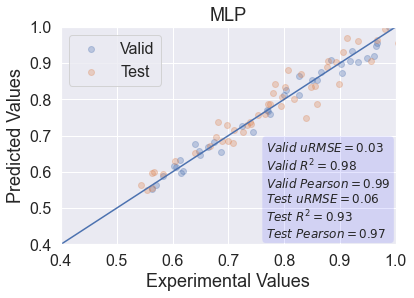

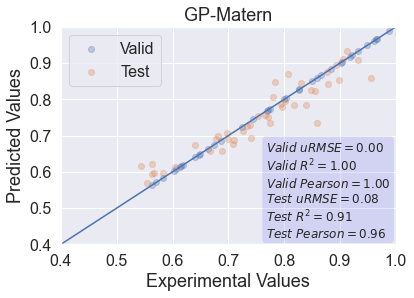

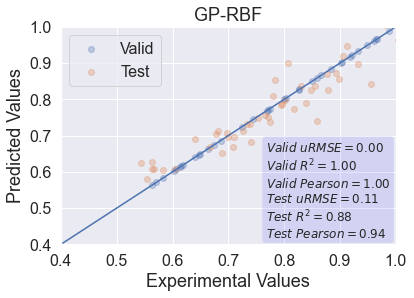

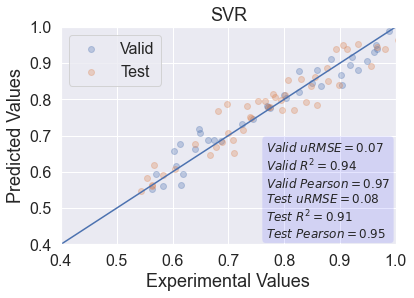

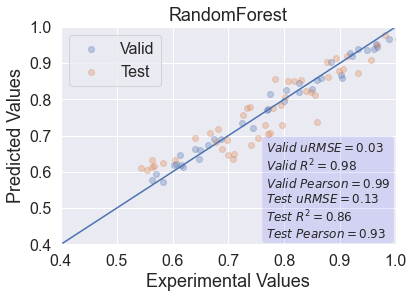

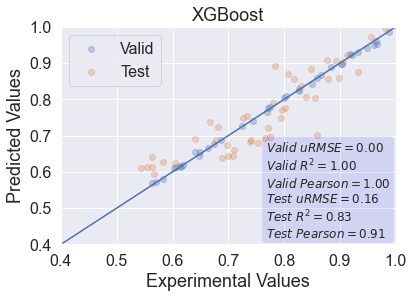

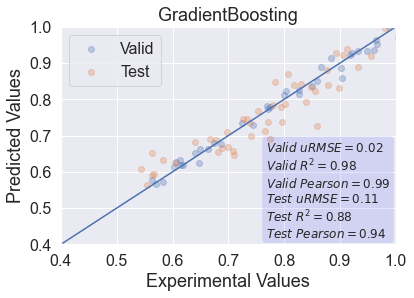

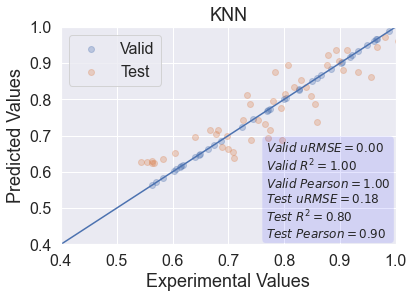

In [22]:
for model_type in model._model_dict:
    fig, ax = plt.subplots()
    for dataset in X_features:
        plt.scatter(Y_ground_truth[dataset], 
                    Y_predict[dataset][model_type], alpha = 0.3, label = dataset)
    plt.xlabel('Experimental Values', fontsize=18)
    plt.ylabel('Predicted Values', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.plot(np.arange(-2.5, 25), np.arange(-2.5, 25), )
    plt.ylim(0.4, 1)
    plt.xlim(0.4, 1)

    plt.title(model_type, fontsize=18)
    textstr = '\n'.join((
    r'$Valid\ uRMSE=%.2f$' % (regression_df['Valid_uRMSE'].loc[model_type], ),
    r'$Valid\ R^{2}=%.2f$' % (regression_df['Valid_R2'].loc[model_type], ),
    r'$Valid\ Pearson=%.2f$' % (regression_df['Valid_Pearson'].loc[model_type], ),
    r'$Test\ uRMSE=%.2f$' % (regression_df['Test_uRMSE'].loc[model_type], ),
    r'$Test\ R^{2}=%.2f$' % (regression_df['Test_R2'].loc[model_type], ),
    r'$Test\ Pearson=%.2f$' % (regression_df['Test_Pearson'].loc[model_type], ),))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='blue', alpha=0.1)

    # place a text box in upper left in axes coords
    ax.text(0.612, 0.48, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.show()